## What factors contribute to lower rates of adolescent maternal mortality long-term?

Machine learning methods are becoming increasingly relevant as data becomes more readily available. These methods enable researchers to expand on their general understanding of the complex dynamic changes in indicators with a significant number of interrelated factors. Additionally, it is possible to make the results, like external factors affecting the incidence of adolescent maternal mortality, interpretable from a clinical point of view.

The following methods consist of: Random Forest Classifier, KNeighbors Classifier, Logistic Regression, and Gaussian Naive Bayes.  For the interpretation of differences between individual parameters of the mothers in two classes predicted failure (maternal mortality) verses prediction success (maternal vitality), the problem of classification via using the decision tree can be solved. The target is prediction failure class.

Target Variable - Percent Above(0) and Below(1) μ Population Age of Maternal Mortality - Binary Logistic Regression

In [254]:
# Import the relevant modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

# Machine Learning modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import GaussianNB

# Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Accuracy
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
# Graphing
from matplotlib.colors import ListedColormap
from sklearn.neighbors import NearestCentroid

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.metrics import classification_report, confusion_matrix

# ROC Curve
from sklearn.metrics import roc_curve

# Error Handling for Random Forest Tree
from sklearn import preprocessing
from sklearn import utils

In [255]:
# Open merged materna_mortal_factors dataset
%store -r metro_gdp_mortality

In [256]:
data = metro_gdp_mortality
data.head()

,State,State Population 2010,State Population 2015,State GDP 2010,State GDP 2015,Increase(0)/No Change(1) GDP,Total μ Age,Total (n),Above(0)/Below(1) Pop μ,Total Age σ2,Above(0)/Below(1) Pop σ2,Adolescent μ Age,Adolescent Age σ2,Adolescent (n),Total % Mortality 2010-15,Ado % Mortality 2010-15
0,Aguascalientes,932369,1044049,16597.0,19528.0,0,28.36,127.0,0,55.16,0,18.08,2.55,25,0.0258,0.0051
1,Baja California,3155070,3315766,52579.0,57136.0,0,27.15,361.0,1,46.31,1,18.00,2.70,69,0.0223,0.0015
4,Baja California Sur,251871,272711,21260.0,21431.0,0,27.56,66.0,1,55.37,0,18.00,3.25,16,0.0504,0.0191
5,Campeche,259005,283025,NaN,NaN,1,26.87,126.0,1,44.29,1,18.00,4.18,22,0.0932,0.0185
6,Chiapas,1058712,1162592,14271.0,13392.0,1,28.02,310.0,1,45.02,1,18.33,2.57,52,0.0559,0.0045


### Dataset Target Variable: Above(0)/Below(1) Population μ

### Visualize Data

#### Assess potential correlation of various factors within each Region
- Create a correlation dataframe
- Plot the correlation dataframe on a sns heatmap:
    - Cells that are in green show positive correlation
    - Cells that are in red show negative correlation

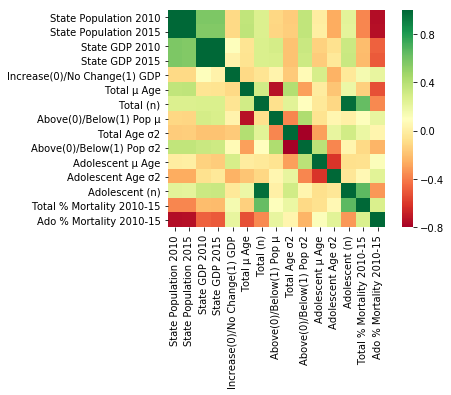

In [257]:
# Create a correlation dataframe
feature_corr = data.corr()

# Plot a correlation heatmap
sns.heatmap(feature_corr, square=True, cmap='RdYlGn')

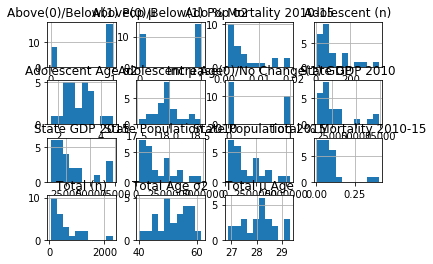

In [258]:
data.hist()
plt.show()

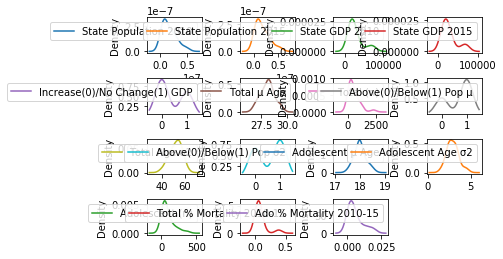

In [259]:
data.plot(kind='kde', subplots=True, layout=(4,4), sharex=False)
plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.show()

#### *Preliminary Observations of Interest*: 
- **Positive (+) Correlation**
    - State Population
        - State GDP
        - μ Age Maternal Mortality
        - Total Maternal Mortality (n)
    - State GDP
        - Above(0)/Below(1) μ Pop Age
        - Adolescent Maternal Mortality (n)
- **Negative (-) Correlation**
    - Adolescent Percent Maternal Mortality
        - State Population
        - State GDP
        - Total Maternal Mortality (n)

#### ( + ) Correlation: Region GDP and GDP 

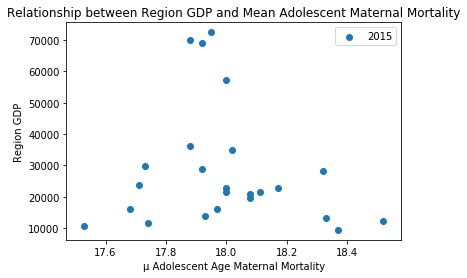

In [260]:
plt.scatter(data['Adolescent μ Age'], data['State GDP 2015'], label='2015')
plt.xlabel("μ Adolescent Age Maternal Mortality")
plt.ylabel("Region GDP")
plt.title("Relationship between Region GDP and Mean Adolescent Maternal Mortality")
plt.legend()

#### ( + ) Correlation: State Population and GDP 

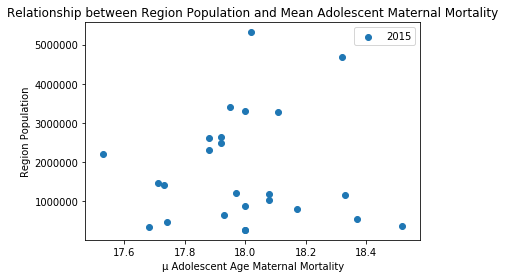

In [261]:
plt.scatter(data['Adolescent μ Age'], data['State Population 2015'], label='2015')
plt.xlabel("μ Adolescent Age Maternal Mortality")
plt.ylabel("Region Population")
plt.title("Relationship between Region Population and Mean Adolescent Maternal Mortality")
plt.legend()

#### ( + ) Correlation: Above(0)/Below(1) μ Age of Maternal Mortality in Mexico with State GDP

Text(0.5,1,'Relationship between μ Age of Maternal Mortality and State GDP')

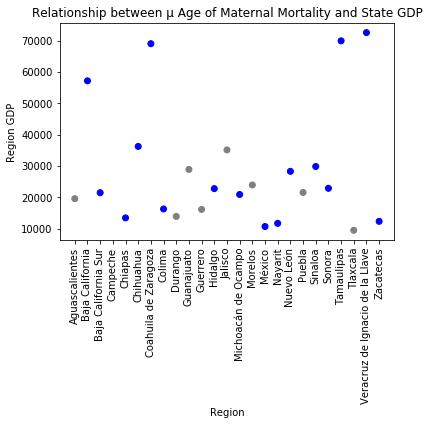

In [262]:
fig, ax = plt.subplots()

#define dot colors
cols = {0: 'grey', 1: 'blue'}

labels = ['Above Country μ', 'Below Country μ']


plt.scatter(x=data['State'], 
            y=data['State GDP 2015'], 
            c=data['Above(0)/Below(1) Pop μ'].map(cols))

# label axes and title
plt.xlabel("Region")
plt.xticks(rotation='vertical')
plt.ylabel("Region GDP")
plt.title("Relationship between μ Age of Maternal Mortality and State GDP")

#### Purpose for Changing all Categorical Strings to a Numeric Value: 
- Machine Learning models will ignore string values (strings have no statistical value unless added)
- Numeric values are comparable therefore string values should be categorically changed to numbers
- This is how you compare a string value to a numeric value that the model can use

In [263]:
# Convert Column value strings to a numeric value
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [264]:
data.head()

,State,State Population 2010,State Population 2015,State GDP 2010,State GDP 2015,Increase(0)/No Change(1) GDP,Total μ Age,Total (n),Above(0)/Below(1) Pop μ,Total Age σ2,Above(0)/Below(1) Pop σ2,Adolescent μ Age,Adolescent Age σ2,Adolescent (n),Total % Mortality 2010-15,Ado % Mortality 2010-15
0,0,932369,1044049,16597.0,19528.0,0,28.36,127.0,0,55.16,0,18.08,2.55,25,0.0258,0.0051
1,1,3155070,3315766,52579.0,57136.0,0,27.15,361.0,1,46.31,1,18.00,2.70,69,0.0223,0.0015
4,2,251871,272711,21260.0,21431.0,0,27.56,66.0,1,55.37,0,18.00,3.25,16,0.0504,0.0191
5,3,259005,283025,20994.5,22120.5,1,26.87,126.0,1,44.29,1,18.00,4.18,22,0.0932,0.0185
6,4,1058712,1162592,14271.0,13392.0,1,28.02,310.0,1,45.02,1,18.33,2.57,52,0.0559,0.0045


## Basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

#### Test-Train-Split:
- X = copy of all features and the response variable of dataset
- y = all features within dataset *excluding the response (target) variable*
- test_size = represents the proportion of the dataset (as a percentage) to include in the test split
- random_state = the seed used by the random number generator

In [265]:
# Entire dataset (even with response variable)
X = data.copy()

# The response variable
y = data.copy().pop('Above(0)/Below(1) Pop μ')

In [266]:
# Create train and test data sets with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=10)
len(X_train), len(X_test), len(y_train), len(y_test)

(18, 7, 18, 7)

#### Logistic Regression
- Round One

In [272]:
# Create a Logistic Regression Incidence 
clf_log = LogisticRegression()

# Fit clf_log to training data
clf_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [273]:
# Examine the coefficients
list(np.transpose(clf_log.coef_))

[array([-0.00012484]),
 array([-1.16909669e-05]),
 array([1.02882444e-05]),
 array([0.00154816]),
 array([-0.00131127]),
 array([-1.17831026e-05]),
 array([-0.00039179]),
 array([-0.004126]),
 array([2.59730639e-05]),
 array([-0.00078159]),
 array([7.11520784e-06]),
 array([-0.00024433]),
 array([-3.95340849e-05]),
 array([-0.00047302]),
 array([-9.97306044e-07]),
 array([-1.06999435e-07])]

In [274]:
# Calculate the class probablity
probability = clf_log.predict_proba(X_test)
probability

array([[7.02734951e-01, 2.97265049e-01],
       [1.05799735e-01, 8.94200265e-01],
       [9.99178294e-01, 8.21706339e-04],
       [1.29378150e-02, 9.87062185e-01],
       [5.45037594e-01, 4.54962406e-01],
       [8.52660123e-02, 9.14733988e-01],
       [1.35181862e-02, 9.86481814e-01]])

In [275]:
# Predict the model
predict = clf_log.predict(X_test)

# Compute the confusion_matrix to evaluate the accuracy of a classification
conf_matrix = confusion_matrix(y_test, predict)
print(conf_matrix)

# Compute classification report
class_report = classification_report(y_test, predict)
print(class_report)

# Print the accuracy from the testing data
accuracy_score(y_test, predict)

[[1 1]
 [2 3]]
             precision    recall  f1-score   support

          0       0.33      0.50      0.40         2
          1       0.75      0.60      0.67         5

avg / total       0.63      0.57      0.59         7



0.5714285714285714

#### Tuning the Model

The f1-score in *class_report* represents the classifier model's accuracy in classifying the data points in that particular class compared to all other class. Since the resulting f1-score and accuracy score is ~71.43%, this is verification that the model is working. However, adding additional parameters, 'C', to the logistic regression instance may increase the accuracy of the model. 

#### Find Optimal 'C' Parameter Value with GridSearchCV

In [276]:
# calculate best 'C' with GridSearchCV
def cv_optimize(clf, parameters, X_train, y_train, n_folds=5):
    
    #Use GridSearchCV to find the best C parameter
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X_train, y_train)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [278]:
#Define possible parameter 'C' range of values
parameters = {"C": [100000, 10000, 1000, 100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001]}

#Apply cv_optimize function to Logistic Regression
clf = cv_optimize(clf_log, parameters, X_train, y_train)
    
#Fit to training data
clf = clf.fit(X_train, y_train)
    
#Assess model accuracy (train and test)
training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

BEST PARAMS {'C': 10000}
Accuracy on training data: 0.89
Accuracy on test data:     0.57


#### Logistic Regression
- Round Two

In [279]:
# Create a Logistic Regression Incidence 
new_clf_log = LogisticRegression(C=10000)

# Fit clf_log to training data
new_clf_log.fit(X_train, y_train)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [280]:
# Examine the coefficients
list(np.transpose(new_clf_log.coef_))

[array([-0.00012484]),
 array([-1.16917002e-05]),
 array([1.02889123e-05]),
 array([0.00154819]),
 array([-0.00131129]),
 array([-1.17830654e-05]),
 array([-0.00039179]),
 array([-0.00412599]),
 array([2.59730347e-05]),
 array([-0.00078158]),
 array([7.11521044e-06]),
 array([-0.00024433]),
 array([-3.95339609e-05]),
 array([-0.00047301]),
 array([-9.97300324e-07]),
 array([-1.06999027e-07])]

In [281]:
# Calculate the class probablity
probability = new_clf_log.predict_proba(X_test)
probability

array([[7.02759369e-01, 2.97240631e-01],
       [1.05810872e-01, 8.94189128e-01],
       [9.99178271e-01, 8.21729412e-04],
       [1.29374987e-02, 9.87062501e-01],
       [5.45042993e-01, 4.54957007e-01],
       [8.52665293e-02, 9.14733471e-01],
       [1.35174653e-02, 9.86482535e-01]])

In [283]:
# Predict the model
new_predict = new_clf_log.predict(X_test)

# Compute the confusion_matrix to evaluate the accuracy of a classification
new_conf_matrix = confusion_matrix(y_test, new_predict)
print(new_conf_matrix)

# Compute classification report
new_class_report = classification_report(y_test, new_predict)
print(new_class_report)

# Print the accuracy from the testing data
accuracy_score(y_test, new_predict)

[[1 1]
 [2 3]]
             precision    recall  f1-score   support

          0       0.33      0.50      0.40         2
          1       0.75      0.60      0.67         5

avg / total       0.63      0.57      0.59         7



0.5714285714285714

**Conclusion**: Unfortunately, as shown above, adding the best value of the C parameter (10000) to the model does not increase it's accuracy. Therefore, the final accuracy of this model will remain at ~57.43%.

### Create Maternal Mortality Strategy Using The Model

In [284]:
data.columns

Index(['State', 'State Population 2010', 'State Population 2015',
       'State GDP 2010', 'State GDP 2015', 'Increase(0)/No Change(1) GDP',
       'Total μ Age', 'Total (n)', 'Above(0)/Below(1) Pop μ', 'Total Age σ2',
       'Above(0)/Below(1) Pop σ2', 'Adolescent μ Age', 'Adolescent Age σ2',
       'Adolescent (n)', 'Total % Mortality 2010-15',
       'Ado % Mortality 2010-15'],
      dtype='object')

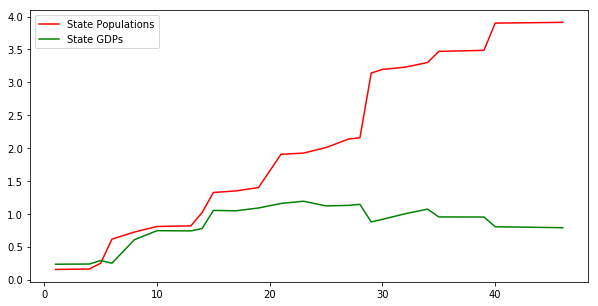

In [155]:
data['Decrease(0)/Not(1) in Ado Maternal Mortality (n) 2010-15'] = clf_log.predict(X)

data['State Population 2015'] = (data['State Population 2015'] - data['State Population 2010'])/data['State Population 2015'].shift(1)
State_Population_prediction = np.cumsum(data['State Population 2015'])

data['State GDP 2015'] = (data['State GDP 2015'] - data['State GDP 2010'])/data['State GDP 2015'].shift(1)
State_GDP_prediction = np.cumsum(data['State GDP 2015'])

plt.figure(figsize=(10,5))
plt.plot(State_Population_prediction, color='r',label = 'State Populations')
plt.plot(State_GDP_prediction, color='g', label = 'State GDPs')
plt.legend()
plt.show()

### It can be observed that the Logistic Regression model in Python predicts the classes with an accuracy of approximately ~57.43% and generates reasonable good predictions.

#### For Random Forest Classifiers:
- n_estimators: choosing 100 is a straight forward value
- max_depth: the level of complexity/freedom - values 2 to 6 is usually fine, though starting at 2 is recommended
- random_state: the seed for the random number generator - makes a model replicatable - any number is fine

In [285]:
# Create a Random Forest Classifier incidence 
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [286]:
# Fit train data to Random Forest Classifier
rfc_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

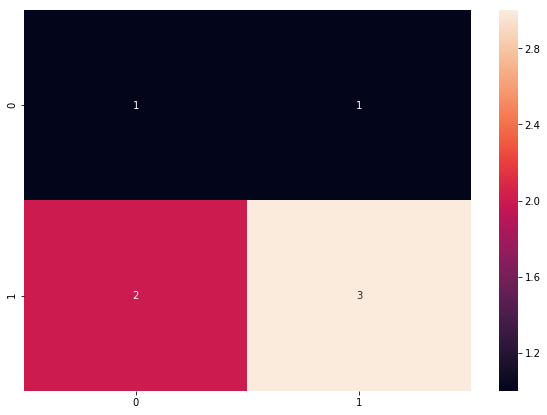

In [287]:
# Plot confusion_matrix
plt.figure(figsize = (10,7))
sns.heatmap(conf_matrix, annot=True)

#### Compute the Root Mean Squared Error (RMSE) 
- Used measure of the differences between values predicted by a model and the values observed 
- RMSE is always non-negative
- A value of 0 would indicate a perfect fit to the data. 
In general, a lower RMSD is better than a higher one. 

In [289]:
# Plot outputs
plt.scatter(X_test, y_pred,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

NameError: name 'y_pred' is not defined

#### K-Neighbors Classification
- Supervised neighbors classification for data with discrete labels

In [71]:
# Define features
features = list(X.keys())
features

['State',
 'State Population 2015',
 'State GDP 2015',
 'μ Age Maternal Mortality',
 'Above(0)/Below(1) μ Pop Age',
 'μ Age Variance',
 'Total Maternal Mortality (n)',
 'μ Age Adolescent Maternal Mortality',
 'μ Age Adolescent Variance',
 'Adolescent Maternal Mortality (n)',
 'Total Percent Maternal Mortality 2015',
 'Adolescent Percent Maternal Mortality 2015']

In [290]:
# Define number of K-Neighbors
neighbors = 8
knn = KNeighborsClassifier(neighbors)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred_knn = knn.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[1 1]
 [2 3]]
             precision    recall  f1-score   support

          0       0.33      0.50      0.40         2
          1       0.75      0.60      0.67         5

avg / total       0.63      0.57      0.59         7



In [291]:
# Predict the labels of the test data: y_pred
y_pred_knn = knn.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[1 1]
 [2 3]]
             precision    recall  f1-score   support

          0       0.33      0.50      0.40         2
          1       0.75      0.60      0.67         5

avg / total       0.63      0.57      0.59         7



In [ ]:
# Plot the decision boundary

# step size in the mesh
h = .02

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for shrinkage in [None, .2]:
    
    #create an instance of Neighbours Classifier
    clf = NearestCentroid(shrink_threshold=shrinkage)
    
    #fit training data
    clf.fit(X_train, y_train)
    
    #predict testing data
    y_pred = clf.predict(X_test)
    print(shrinkage, np.mean(y_train == y_pred))
    
    # assign a color to each point in the mesh [x_min, x_max] x[y_min, y_max]
    x_min, x_max = X['State GDP 2015'].min() - 1, X['State GDP 2015'].max() + 1
    
    # target variable is binary
    y_min, y_max = 0, 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X_train, y_train, c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.title("3-Class classification (shrink_threshold=%r)"
              % shrinkage)
    plt.axis('tight')

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


None 0.0
